In [1]:
rm(list = ls())
options(stringsAsFactors = F)
gc()
library(data.table)
library(survival)
library(survminer)
library(WGCNA)
source('./00.data/fun.R',print.eval = TRUE)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,595673,31.9,1271077,67.9,1271077,67.9
Vcells,1064628,8.2,8388608,64.0,1649361,12.6


Warning message:
"程辑包'data.table'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'survival'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'survminer'是用R版本4.1.3 来建造的"
载入需要的程辑包：ggplot2

Warning message:
"程辑包'ggplot2'是用R版本4.1.3 来建造的"
载入需要的程辑包：ggpubr

Warning message:
"程辑包'ggpubr'是用R版本4.1.3 来建造的"

载入程辑包：'survminer'


The following object is masked from 'package:survival':

    myeloma


Warning message:
"程辑包'WGCNA'是用R版本4.1.3 来建造的"
载入需要的程辑包：dynamicTreeCut

载入需要的程辑包：fastcluster


载入程辑包：'fastcluster'


The following object is masked from 'package:stats':

    hclust





载入程辑包：'WGCNA'


The following object is masked from 'package:stats':

    cor




In [2]:
clinical <- './00.data/01.TCGA/TCGA-LIHC.survival.tsv'
CIBERSOFT <- './00.data/01.TCGA/CIBERSOFT.txt'

In [3]:
rt <- Processing_1(clinical,CIBERSOFT)

if (!dir.exists("01.CIBERSOFT_survival")){
  dir.create("01.CIBERSOFT_survival")
}


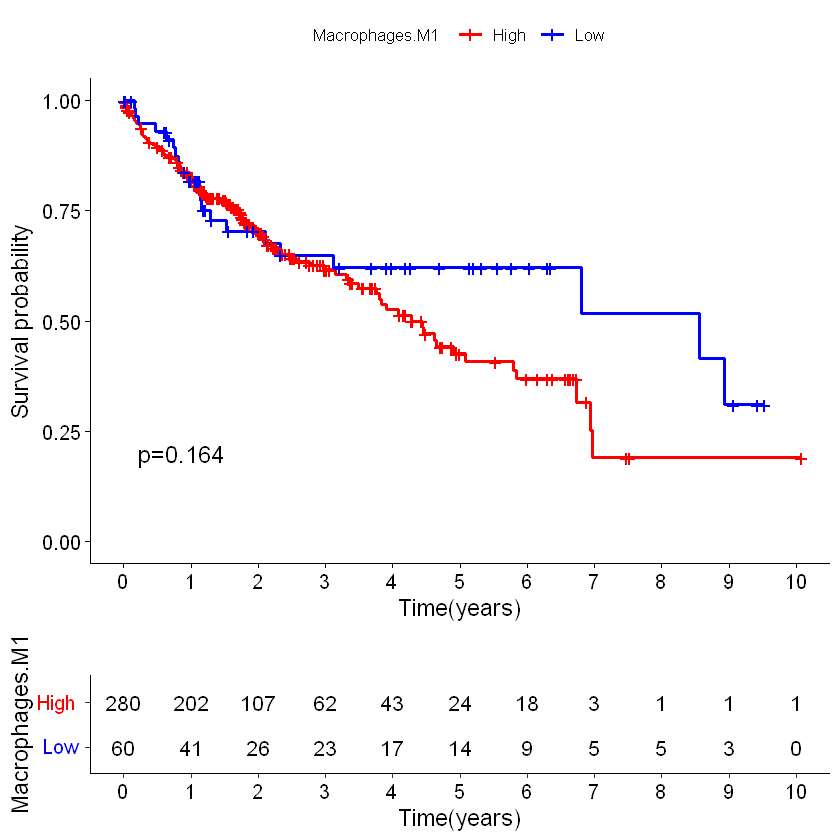

In [4]:
data=rt[,c("futime","fustat","Macrophages.M1")]
  res.cut=surv_cutpoint(rt, time = "futime", event = "fustat",variables ="Macrophages.M1")
  res.cat=surv_categorize(res.cut)
  fit=survfit(Surv(futime, fustat) ~res.cat[,"Macrophages.M1"], data = res.cat)
  diff=survdiff(Surv(futime, fustat) ~res.cat[,"Macrophages.M1"],data =res.cat)
  pValue=1-pchisq(diff$chisq,df=1)
  if(pValue<0.001){
    pValue="p<0.001"
  }else{
    pValue=paste0("p=",sprintf("%.03f",pValue))
  }
  surPlot=ggsurvplot(fit, 
                     data=res.cat,
                     #conf.int=TRUE,
                     pval=pValue,
                     pval.size=5,
                     legend.labs=c("High", "Low"),
                     legend.title= "Macrophages.M1",
                     xlab="Time(years)",
                     break.time.by = 1,
                     risk.table.title="",
                     palette=c("red", "blue"),
                     risk.table=T,
                     risk.table.height=.25)
print(surPlot)

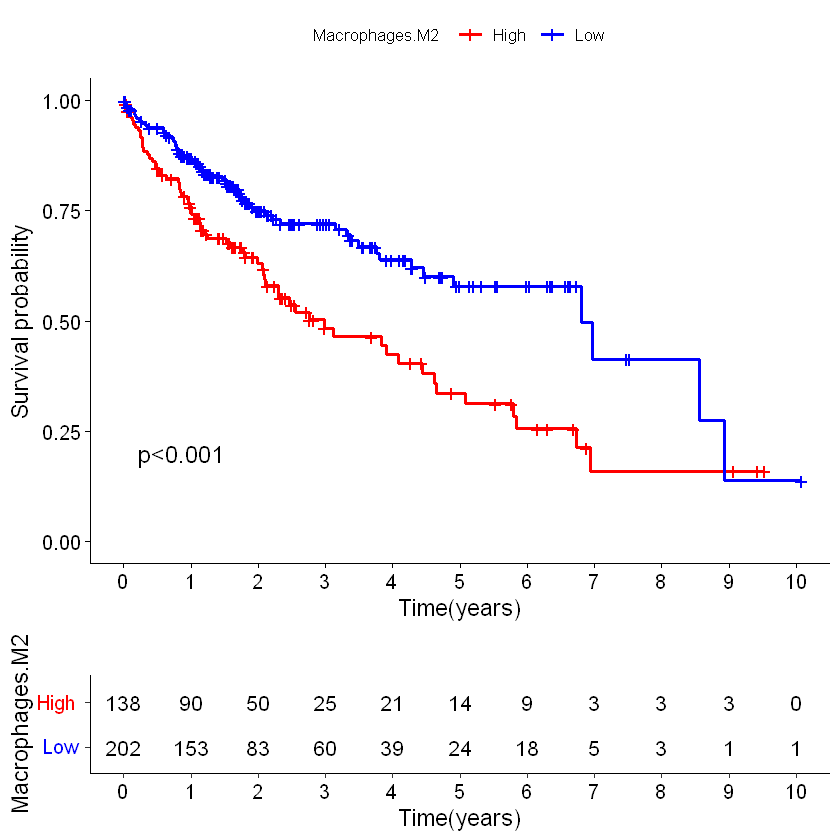

In [5]:
data=rt[,c("futime","fustat","Macrophages.M2")]
  res.cut=surv_cutpoint(rt, time = "futime", event = "fustat",variables ="Macrophages.M2")
  res.cat=surv_categorize(res.cut)
  fit=survfit(Surv(futime, fustat) ~res.cat[,"Macrophages.M2"], data = res.cat)
  diff=survdiff(Surv(futime, fustat) ~res.cat[,"Macrophages.M2"],data =res.cat)
  pValue=1-pchisq(diff$chisq,df=1)
  if(pValue<0.001){
    pValue="p<0.001"
  }else{
    pValue=paste0("p=",sprintf("%.03f",pValue))
  }
  surPlot=ggsurvplot(fit, 
                     data=res.cat,
                     #conf.int=TRUE,
                     pval=pValue,
                     pval.size=5,
                     legend.labs=c("High", "Low"),
                     legend.title= "Macrophages.M2",
                     xlab="Time(years)",
                     break.time.by = 1,
                     risk.table.title="",
                     palette=c("red", "blue"),
                     risk.table=T,
                     risk.table.height=.25)
print(surPlot)

In [6]:
wgcna_inputfile <- './00.data/02.WGCNA/TCGA-LIHC.txt'
data <-read.table(wgcna_inputfile,header = T,row.names = 1,check.names = F,sep = '\t')
data=log2(data+1)
data=data[apply(data,1,sd)>0.5,]
datExpr0=t(data)

In [7]:
###Check for missing values
gsg = goodSamplesGenes(datExpr0, verbose = 3)
if (!gsg$allOK){
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0)
    printFlush(paste("Removing genes:", paste(names(datExpr0)[!gsg$goodGenes], collapse = ", ")))
  if (sum(!gsg$goodSamples)>0)
    printFlush(paste("Removing samples:", paste(rownames(datExpr0)[!gsg$goodSamples], collapse = ", ")))
  # Remove the offending genes and samples from the data:
  datExpr0 = datExpr0[gsg$goodSamples, gsg$goodGenes]
}

 Flagging genes and samples with too many missing values...
  ..step 1


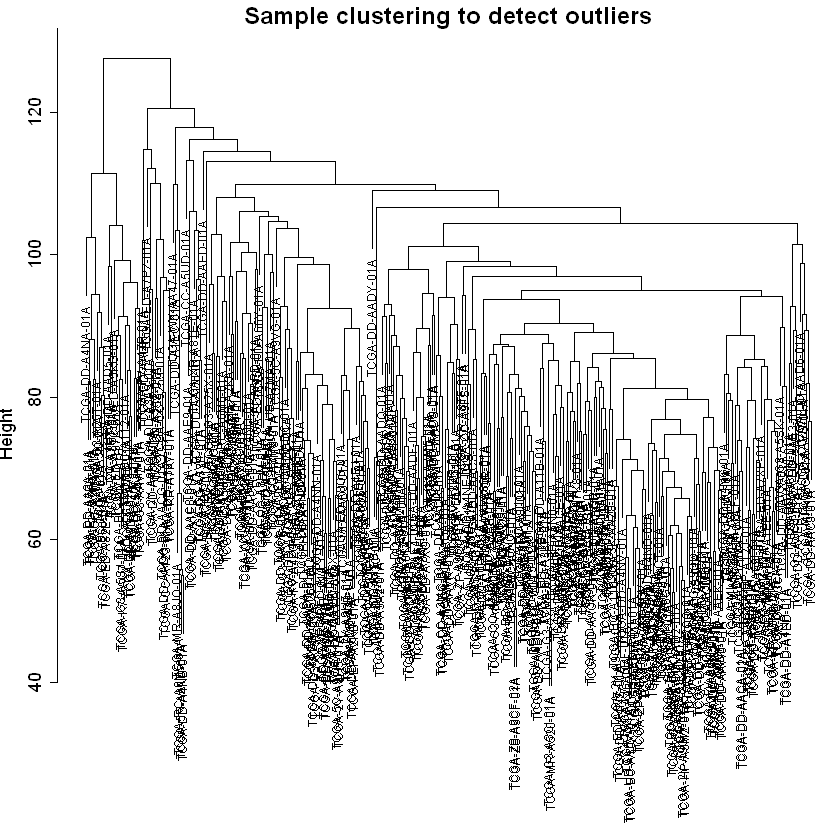

In [11]:
sampleTree = hclust(dist(datExpr0), method = "average")
par(cex = 0.6)
par(mar = c(0,4,2,0))
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5, cex.axis = 1.5, cex.main = 2)
abline(h = 140, col = "red")

In [12]:
clust = cutreeStatic(sampleTree, cutHeight = 140, minSize = 10)
table(clust)
keepSamples = (clust==1)
datExpr0 = datExpr0[keepSamples, ]

clust
  1 
336 

In [13]:
traitData <- './00.data/02.WGCNA/traitData.txt'
traitData <- read.table(traitData,sep = '\t',header = T,check.names = F,row.names = 1)
fpkmSamples = rownames(datExpr0)
traitSamples =rownames(traitData)
sameSample=intersect(fpkmSamples,traitSamples)
datExpr0=datExpr0[sameSample,]
datTraits=traitData[sameSample,]

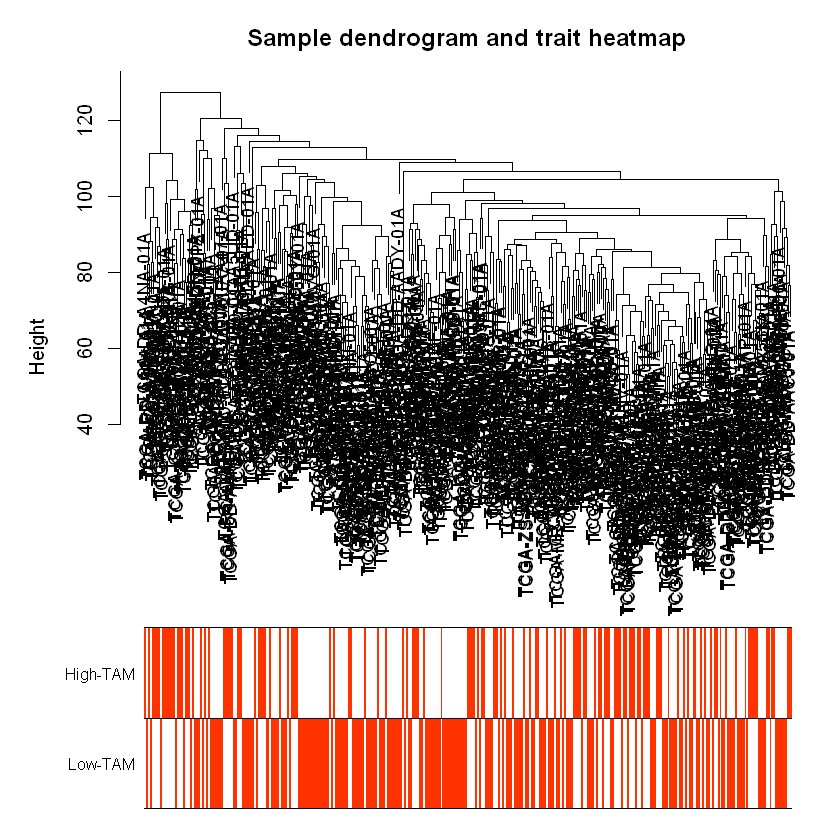

In [14]:
sampleTree2 = hclust(dist(datExpr0), method = "average")
traitColors = numbers2colors(datTraits, signed = FALSE)
plotDendroAndColors(sampleTree2, traitColors,
                    groupLabels = names(datTraits),
                    main = "Sample dendrogram and trait heatmap")

In [15]:
enableWGCNAThreads()   
powers = c(1:40) 
sft = pickSoftThreshold(datExpr0, powerVector = powers, verbose = 5)

Allowing parallel execution with up to 15 working processes.
pickSoftThreshold: will use block size 6072.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 6072 of 7368
   ..working on genes 6073 through 7368 of 7368
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.  max.k.
1      1    0.188  1.230          0.907 1.14e+03  1.14e+03 1920.00
2      2    0.259 -0.845          0.899 2.91e+02  2.71e+02  756.00
3      3    0.669 -1.580          0.962 9.80e+01  8.10e+01  388.00
4      4    0.789 -1.810          0.981 3.98e+01  2.76e+01  225.00
5      5    0.842 -1.860          0.991 1.86e+01  1.03e+01  141.00
6      6    0.845 -1.870          0.985 9.67e+00  4.19e+00   93.50
7      7    0.856 -1.790          0.984 5.49e+00  1.81e+00   64.20
8      8    0.884 -1.670          0.984 3.34e+00  8.16e-01   45.30
9      9    0.934 -1.510          0.986 2.16e+00  3.92e-01   32.60
10    10    0.883 -1.580          0.960 1.46e+00  1.94e-01   27.30

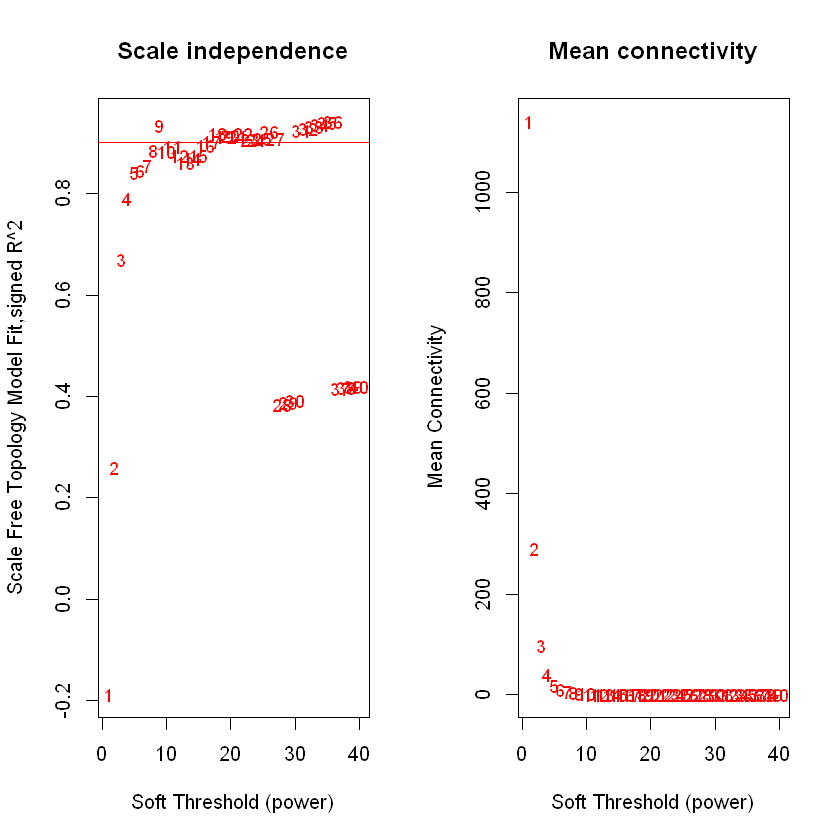

In [16]:
par(mfrow = c(1,2))
cex1 = 0.9
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red");
abline(h=0.90,col="red") 
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

In [17]:
###Adjacency matrix conversion
softPower =sft$powerEstimate #Optimal power value
print(softPower)

[1] 7


In [18]:
adjacency = adjacency(datExpr0, power = softPower)

###TOM  Matrix
TOM = TOMsimilarity(adjacency)
dissTOM = 1-TOM

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


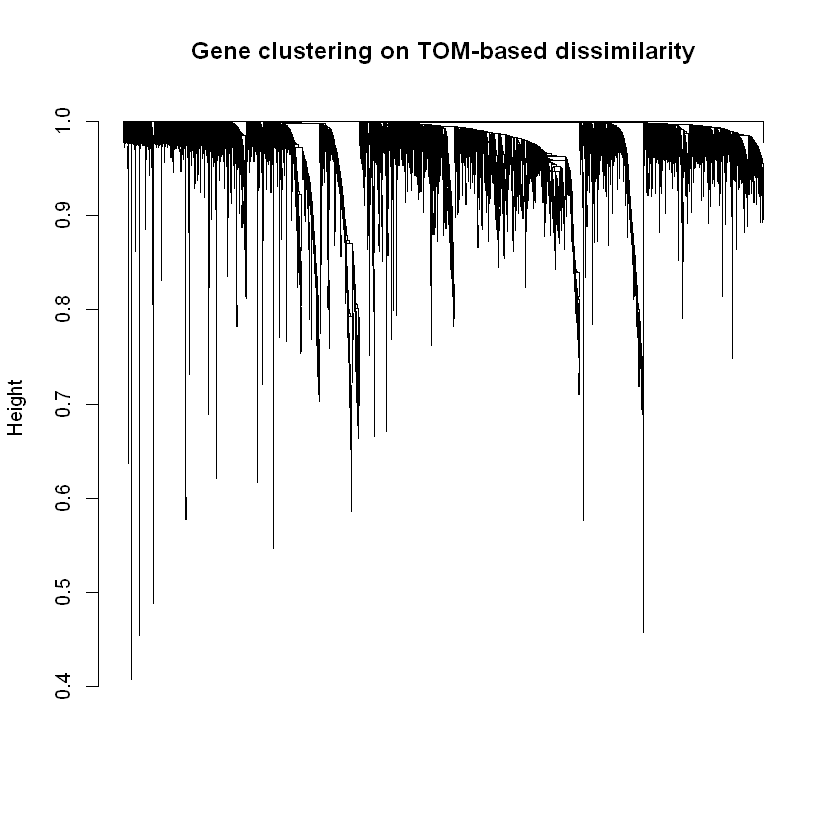

In [19]:
geneTree = hclust(as.dist(dissTOM), method = "average");
plot(geneTree, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",
     labels = FALSE, hang = 0.04)

In [20]:
###Dynamic cut module recognition
minModuleSize = 50  #Minimum number of module genes
dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM,
                            deepSplit = 2, pamRespectsDendro = FALSE,
                            minClusterSize = minModuleSize);
table(dynamicMods)
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)

 ..cutHeight not given, setting it to 0.998  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods
   0    1    2    3    4    5    6    7    8    9   10   11   12   13 
1184 1340 1036  831  660  599  405  404  266  173  146  119  117   88 

dynamicColors
      black        blue       brown       green greenyellow        grey 
        404        1036         831         599         119        1184 
    magenta        pink      purple         red      salmon         tan 
        173         266         146         405          88         117 
  turquoise      yellow 
       1340         660 

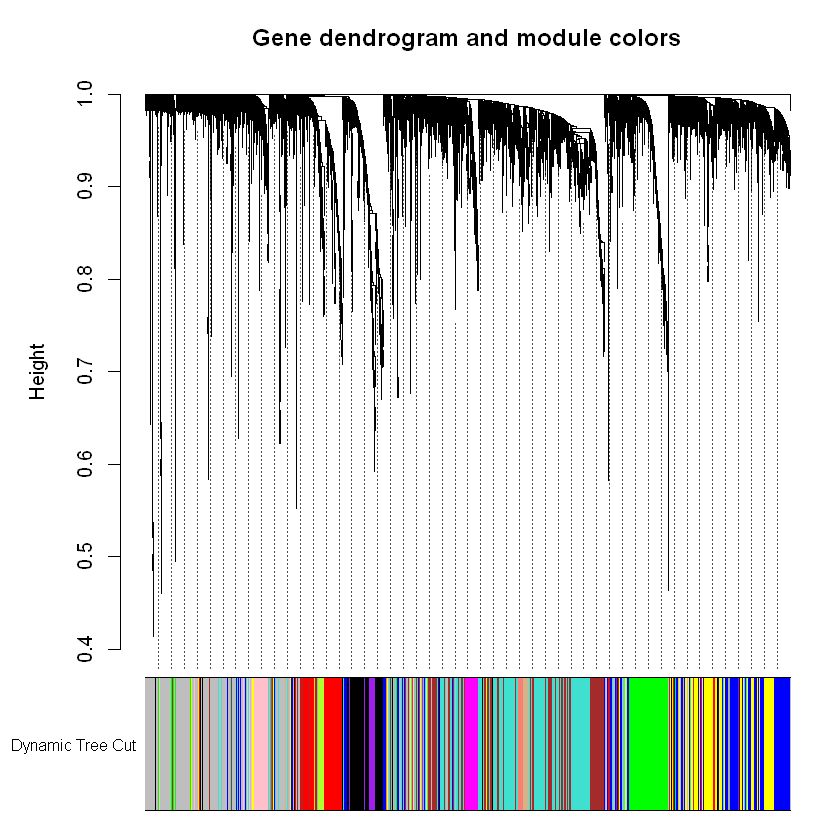

In [21]:
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05,
                    main = "Gene dendrogram and module colors")

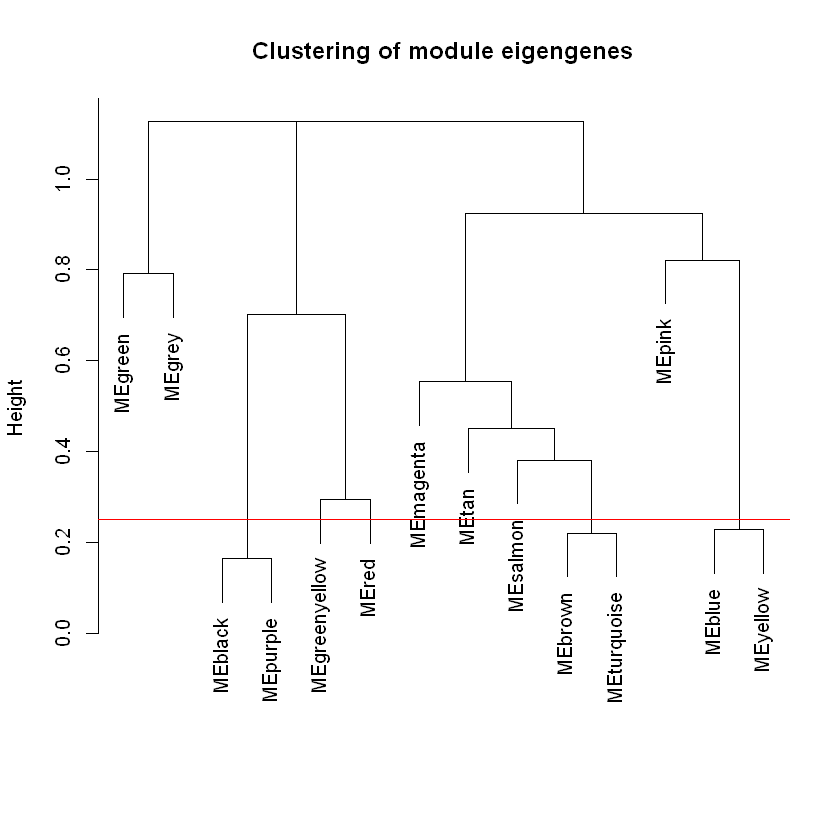

In [22]:
MEList = moduleEigengenes(datExpr0, colors = dynamicColors)
MEs = MEList$eigengenes
MEDiss = 1-cor(MEs);
METree = hclust(as.dist(MEDiss), method = "average")
plot(METree, main = "Clustering of module eigengenes",
     xlab = "", sub = "")
MEDissThres = 0.25 
abline(h=MEDissThres, col = "red")

 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 14 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.


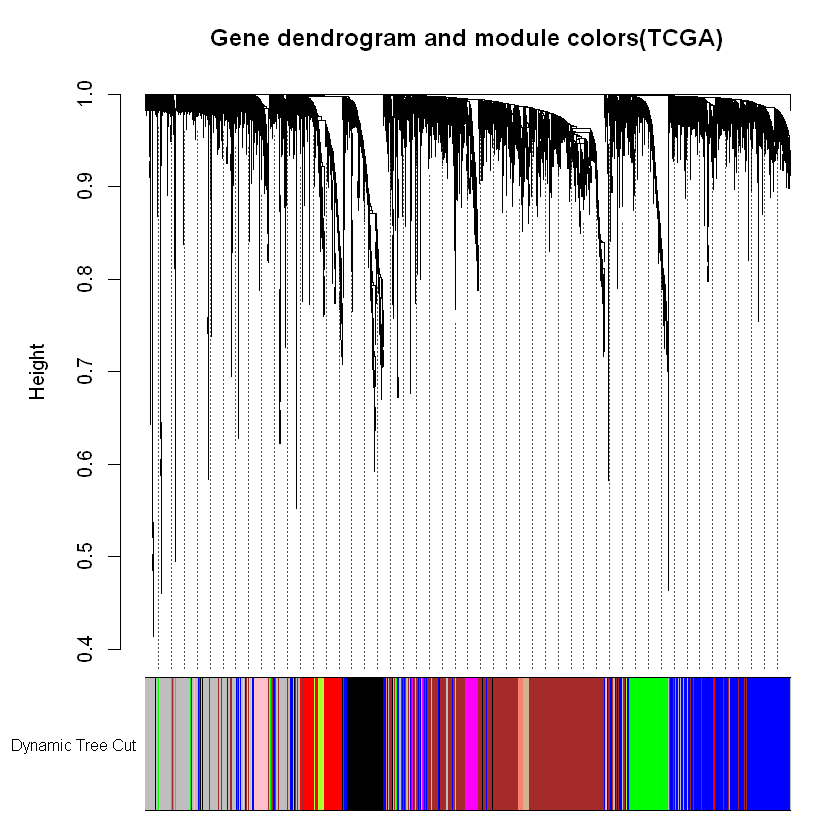

In [23]:
merge = mergeCloseModules(datExpr0, dynamicColors, cutHeight = MEDissThres, verbose = 3)
mergedColors = merge$colors
mergedMEs = merge$newMEs
plotDendroAndColors(geneTree, mergedColors,"Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05,
                    main = "Gene dendrogram and module colors(TCGA)")

In [24]:
moduleColors = mergedColors
table(moduleColors)
colorOrder = c("grey", standardColors(50))
moduleLabels = match(moduleColors, colorOrder)-1
MEs = mergedMEs

moduleColors
      black        blue       brown       green greenyellow        grey 
        550        1696        2171         599         119        1184 
    magenta        pink         red      salmon         tan 
        173         266         405          88         117 

In [25]:
nGenes = ncol(datExpr0)
nSamples = nrow(datExpr0)
moduleTraitCor = cor(MEs, datTraits, use = "p")
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples)

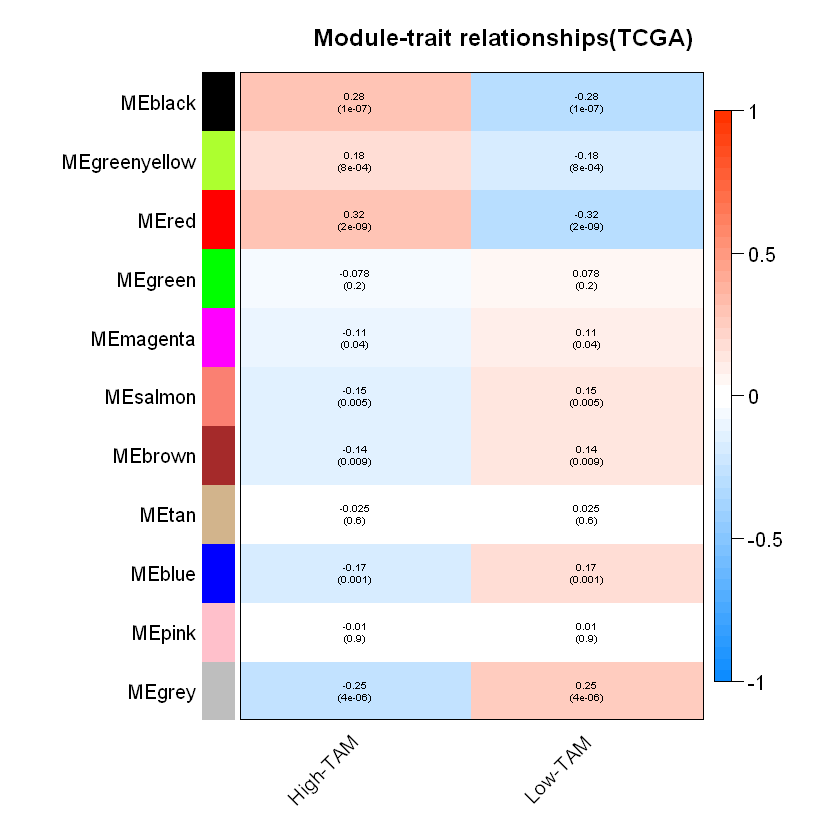

In [26]:
textMatrix = paste(signif(moduleTraitCor, 2), "\n(",
                   signif(moduleTraitPvalue, 1), ")", sep = "")
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(5, 10, 3, 3))
labeledHeatmap(Matrix = moduleTraitCor,
               xLabels = names(datTraits),
               yLabels = names(MEs),
               ySymbols = names(MEs),
               colorLabels = FALSE,
               colors = blueWhiteRed(50),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 0.5,
               zlim = c(-1,1),
               main = paste("Module-trait relationships(TCGA)"))